# Import Libraries

In [127]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 95.8 MB/s eta 0:00:00


In [128]:
import csv
import pandas as pd
import numpy as np
import torch
from torch import nn
import ast
import transformers
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from transformers import pipeline
from transformers import BertTokenizer,BertModel

# Data Preprocessing

In [ ]:
df = pd.read_csv('train.csv')
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [ ]:
def create_label(row):
    # Perform your custom operation on the two entries from the row
    label = [row['Computer Science'], row['Physics'], row['Mathematics'], row['Statistics'], row['Quantitative Biology'], row['Quantitative Finance']]
    return label
df['label'] = df.apply(create_label, axis=1)
df.to_csv('added_label_dataset.csv', index=False)
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,label
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]"
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]"
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]"
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,"[0, 0, 1, 0, 0, 0]"
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[1, 0, 0, 1, 0, 0]"


In [3]:
table = pd.read_csv("added_label_dataset.csv")
table.drop(['ID','TITLE','Computer Science','Physics','Mathematics','Statistics','Quantitative Biology','Quantitative Finance'], inplace=True, axis=1)
table.head()

,ABSTRACT,label
0,Predictive models allow subject-specific inf...,"[1, 0, 0, 0, 0, 0]"
1,Rotation invariance and translation invarian...,"[1, 0, 0, 0, 0, 0]"
2,We introduce and develop the notion of spher...,"[0, 0, 1, 0, 0, 0]"
3,The stochastic Landau--Lifshitz--Gilbert (LL...,"[0, 0, 1, 0, 0, 0]"
4,Fourier-transform infra-red (FTIR) spectra o...,"[1, 0, 0, 1, 0, 0]"


In [4]:
df = pd.DataFrame()
df['input'] = table['ABSTRACT']
df['label'] = table['label']

def func(input):
  return ast.literal_eval(input)

df['label'] = df['label'].apply(func)

df.head()

,input,label
0,Predictive models allow subject-specific inf...,"[1, 0, 0, 0, 0, 0]"
1,Rotation invariance and translation invarian...,"[1, 0, 0, 0, 0, 0]"
2,We introduce and develop the notion of spher...,"[0, 0, 1, 0, 0, 0]"
3,The stochastic Landau--Lifshitz--Gilbert (LL...,"[0, 0, 1, 0, 0, 0]"
4,Fourier-transform infra-red (FTIR) spectra o...,"[1, 0, 0, 1, 0, 0]"


# Dataset and Dataloader

In [5]:
class mydataset(Dataset):
    def __init__(self, df):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.data = df
        self.input = df.input
        self.label = self.data.label

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        inputs = self.tokenizer(self.input[index],padding='max_length', truncation=True, max_length=512, return_tensors="pt")
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.label[index], dtype=torch.float)
        }

In [6]:
train_data=df.sample(frac=0.85)
test_data=df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

train_set = mydataset(train_data)
test_set = mydataset(test_data)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df.to_csv("/content/drive/My Drive/added_label_dataset.csv", index=False)

# BERT Model Fine-Tune

In [132]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.linear1 = nn.Linear(768, 768)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(768,6)

    def forward(self, input_ids, attention_mask, token_type_ids):
        l1_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_input = l1_output.pooler_output
        x = self.linear2(self.relu1(self.linear1(cls_input)))

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mymodel = BERTClass()
mymodel.to(device)
torch.save(mymodel, 'mybertmodel.pt')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def train(model, train_dataloader, epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    train_losses = []
    best_train_loss = float('inf')


    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for _,data in tqdm(enumerate(train_dataloader, 0)):
          ids = data['ids'].to(device, dtype = torch.long).squeeze()
          mask = data['mask'].to(device, dtype = torch.long).squeeze()
          token_type_ids = data['token_type_ids'].to(device, dtype = torch.long).squeeze()
          targets = data['targets'].to(device, dtype = torch.float)
          outputs = model(input_ids=ids, attention_mask=mask, token_type_ids = token_type_ids)
          
          optimizer.zero_grad()
          loss = criterion(outputs, targets)
          loss.backward()
          optimizer.step()
        
          train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)
        print("complete a epoch")
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

0it [00:00, ?it/s]<ipython-input-8-3c567ce312e6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'ids': torch.tensor(ids, dtype=torch.long),
<ipython-input-8-3c567ce312e6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mask': torch.tensor(mask, dtype=torch.long),
<ipython-input-8-3c567ce312e6>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
558it [07:22,  1.26it/s]


complete a epoch


558it [07:19,  1.27it/s]


complete a epoch


558it [07:19,  1.27it/s]


complete a epoch


558it [07:19,  1.27it/s]


complete a epoch


558it [07:19,  1.27it/s]


complete a epoch


558it [07:19,  1.27it/s]


complete a epoch


558it [07:19,  1.27it/s]


complete a epoch


558it [07:19,  1.27it/s]


complete a epoch


558it [07:19,  1.27it/s]


complete a epoch


558it [07:19,  1.27it/s]


complete a epoch


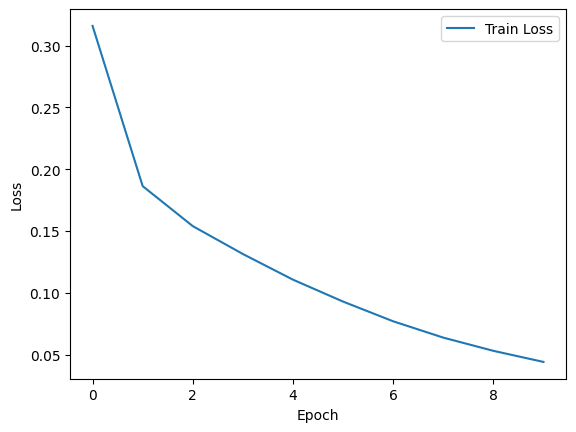

In [ ]:
train(mymodel, train_loader,10, 1e-05)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(mymodel, 'finetuned_mybertmodel.pt')


In [ ]:
torch.save(mymodel, "/content/drive/My Drive/mybertmodel.pt")

# Evaluation and Inference

In [133]:
mymodel = torch.load("/content/drive/My Drive/model.pth",map_location=torch.device('cpu'))

In [9]:
def model_prediction(model, test_loader):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  prediction = []
  label = []
  with torch.no_grad():
    for _,data in tqdm(enumerate(test_loader, 0)):
      ids = data['ids'].to(device, dtype = torch.long).squeeze()
      mask = data['mask'].to(device, dtype = torch.long).squeeze()
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long).squeeze()
      targets = data['targets'].to(device, dtype = torch.float)
      outputs = model(input_ids=ids, attention_mask=mask, token_type_ids = token_type_ids).to("cpu")
      prediction.append(outputs)
      label.append(data['targets'].to("cpu"))

  return prediction, label

In [11]:
prediction, label = model_prediction(mymodel, test_loader)

0it [00:00, ?it/s]<ipython-input-5-3c567ce312e6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'ids': torch.tensor(ids, dtype=torch.long),
<ipython-input-5-3c567ce312e6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'mask': torch.tensor(mask, dtype=torch.long),
<ipython-input-5-3c567ce312e6>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
99it [00:33,  2.99it/s]


In [16]:
np.save('prediction.npy', np.array(prediction))
np.save('label.npy',np.array(label))

<ipython-input-16-3524838c5875>:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.save('prediction.npy', np.array(prediction))
<ipython-input-16-3524838c5875>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('prediction.npy', np.array(prediction))
<ipython-input-16-3524838c5875>:2: FutureWarning: The input object of type 'Tensor' is an array-like implement

In [2]:
label = np.load('label.npy', allow_pickle=True)
prediction = np.load('prediction.npy',allow_pickle=True)

In [15]:
torch.sigmoid(prediction[0][25])

tensor([9.8963e-01, 7.1679e-04, 1.0805e-03, 8.4371e-01, 2.4962e-04, 4.1859e-05])

In [116]:
def hamming_loss(threshold,prediction,label):
  error = 0
  for i in range(len(prediction) - 1):
    predict_step = (torch.sigmoid(prediction[i]) >= threshold).float()
    xor_result = label[i].ne(predict_step)
    error = error + xor_result.sum()
    #print(error.item() / (6*32))
  return error.item() / (6 * 3146)

In [123]:
threshold_loss = [1] + [0] * 9
for i in range(1,10):
  threshold_loss[i] = hamming_loss((i)*0.1, prediction,label)

min_index = np.argmin(np.array(threshold_loss))
min_value = threshold_loss[min_index]
print("the best threshold value is ", min_index * 0.1, ", the best hamming loss is ", min_value)

the best threshold value is  0.5 , the best hamming loss is  0.015787243059970334


In [144]:
def inference(model, abstract):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  model.eval()
  
  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', output_hidden_states=True)
  encoded_input = tokenizer(abstract, return_tensors='pt')
  with torch.no_grad():
    output = model(input_ids=encoded_input['input_ids'].to(device), attention_mask= encoded_input['attention_mask'].to(device),token_type_ids = encoded_input['token_type_ids'].to(device))
  cat = ['Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
  prediction =[]
  for i in range(6):
    if (torch.sigmoid(output) >= 0.5).squeeze()[i] == 1:
      prediction.append(cat[i])
  return prediction

In [154]:
abstract = "  We consider the problem of estimating the $L_1$ distance between two discrete \
probability measures $P$ and $Q$ from empirical data in a nonasymptotic and \
large alphabet setting. When $Q$ is known and one obtains $n$ samples from $P$, \
we show that for every $Q$, the minimax rate-optimal estimator with $n$ samples \
achieves performance comparable to that of the maximum likelihood estimator \
(MLE) with $n\ln n$ samples. When both $P$ and $Q$ are unknown, we construct \
minimax rate-optimal estimators whose worst case performance is essentially \
that of the known $Q$ case with $Q$ being uniform, implying that $Q$ being \
uniform is essentially the most difficult case. The \emph{effective sample size \
enlargement} phenomenon, identified in Jiao \emph{et al.} (2015), holds both in \
the known $Q$ case for every $Q$ and the $Q$ unknown case. However, the \
construction of optimal estimators for $\|P-Q\|_1$ requires new techniques and \
insights beyond the approximation-based method of functional estimation in Jiao \
\emph{et al.} (2015). "

title = "Minimax Estimation of the $L_1$ Distance"

In [155]:
predict = inference(mymodel, abstract)

In [156]:
print(predict)

['Mathematics', 'Statistics']
